In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import to_categorical

In [5]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def categorical_cross_entropy(y_pred, y_true):
    m = y_true.shape[0] # количество примеров

    log = -np.log(y_pred[np.arange(m), np.argmax(y_true, axis=1)])
    loss = np.sum(log) / m
    return loss


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Нормализация изображений
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    y_train_one_hot = to_categorical(y_train, 10)
    y_test_one_hot = to_categorical(y_test, 10)

     # y_test для расчета accuracy
    return x_train, y_train_one_hot, x_test, y_test_one_hot, y_test

In [6]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Инициализация весов и смещений
        self.W1 = np.random.randn(input_size, hidden_size) 
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) 
        self.b2 = np.zeros((1, output_size))

        self.hist = {}

    def forward(self, X):
        # X: (batch_size, input_size)
        # Скрытый слой
        self.hist['Z1'] = X @ self.W1 + self.b1 # (batch_size, hidden_size)
        self.hist['A1'] = relu(self.hist['Z1']) # (batch_size, hidden_size)

        # Выходной слой
        self.hist['Z2'] = self.hist['A1'] @ self.W2 + self.b2 # (batch_size, output_size)
        A2 = softmax(self.hist['Z2']) # (batch_size, output_size)
        self.hist['A2'] = A2
        return A2

    def backward(self, X, y_true):
        # y_true: (batch_size, output_size)
        m = X.shape[0]

        A1 = self.hist['A1']
        A2 = self.hist['A2']
        Z1 = self.hist['Z1']

        # dL/dZ2 = A2 - Y 
        dZ2 = A2 - y_true # (batch_size, output_size)

        # dL/dW2 = dL/dZ2 * dZ2/dW2 = dL/dZ2 * A1.T
        self.dW2 = (1/m) * (A1.T @ dZ2) # (hidden_size, output_size)

        # dL/db2 = dL/dZ2 * dZ2/db2 = dL/dZ2 * 1
        self.db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True) # (1, output_size)

        # dL/dA1 = dL/dZ2 * dZ2/dA1 = dZ2 @ W2.T
        dA1 = dZ2 @ self.W2.T # (batch_size, hidden_size)

        # dL/dZ1 = dL/dA1 * dA1/dZ1 = dA1 * relu_derivative(Z1)
        dZ1 = dA1 * relu_derivative(Z1) # (batch_size, hidden_size)

        # dL/dW1 = dL/dZ1 * dZ1/dW1 = X.T @ dZ1
        self.dW1 = (1/m) * (X.T @ dZ1) # (input_size, hidden_size)

        # dL/db1 = dL/dZ1 * dZ1/db1 = dL/dZ1 * 1
        self.db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True) # (1, hidden_size)

    def update_parameters(self, learning_rate):
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2

    def predict(self, X):
        A2 = self.forward(X)
        return np.argmax(A2, axis=1)

    def evaluate(self, X_test, y_test_orig): 
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == y_test_orig)
        return accuracy

In [8]:
INPUT_SIZE = 784  # 28x28 
HIDDEN_SIZE = 128 # Количество нейронов в скрытом слое
OUTPUT_SIZE = 10  # 10 классов (цифры 0-9)
LEARNING_RATE = 0.1
EPOCHS = 20
BATCH_SIZE = 64

print("Загрузка MNIST")
x_train, y_train_one_hot, x_test, y_test_one_hot, y_test_orig = load_mnist()
print(f"Размер обуч выборки: X={x_train.shape}, Y={y_train_one_hot.shape}")
print(f"Размер тест выборки: X={x_test.shape}, Y={y_test_one_hot.shape}")

model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
train_losses = []
test_accuracies = []

print(f"\nНачало обучения: {EPOCHS} эпох, размер батча {BATCH_SIZE}, скорость обучения {LEARNING_RATE}")

for epoch in range(EPOCHS):
    epoch_loss = 0

    cur = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[cur]
    y_train_shuffled = y_train_one_hot[cur]

    for i in range(0, x_train.shape[0], BATCH_SIZE):
        X_batch = x_train_shuffled[i:i+BATCH_SIZE]
        y_batch = y_train_shuffled[i:i+BATCH_SIZE]

        y_pred_batch = model.forward(X_batch)
        loss = categorical_cross_entropy(y_pred_batch, y_batch)
        epoch_loss += loss * X_batch.shape[0] 

        model.backward(X_batch, y_batch)

        model.update_parameters(LEARNING_RATE)

    avg_epoch_loss = epoch_loss / x_train.shape[0]
    train_losses.append(avg_epoch_loss)

    accuracy = model.evaluate(x_test, y_test_orig)
    test_accuracies.append(accuracy)

    print(f"Эпоха {epoch+1}/{EPOCHS} - Потери: {avg_epoch_loss:.4f} - Точность на тесте: {accuracy:.4f}")

final_accuracy = model.evaluate(x_test, y_test_orig)
print(f"\nИтоговая точность на тестовом наборе: {final_accuracy:.4f}")


Загрузка MNIST
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Размер обуч выборки: X=(60000, 784), Y=(60000, 10)
Размер тест выборки: X=(10000, 784), Y=(10000, 10)

Начало обучения: 20 эпох, размер батча 64, скорость обучения 0.1
Эпоха 1/20 - Потери: 3.7639 - Точность на тесте: 0.8734
Эпоха 2/20 - Потери: 0.9165 - Точность на тесте: 0.8578
Эпоха 3/20 - Потери: 0.5861 - Точность на тесте: 0.8961
Эпоха 4/20 - Потери: 0.4507 - Точность на тесте: 0.9113
Эпоха 5/20 - Потери: 0.3781 - Точность на тесте: 0.9144
Эпоха 6/20 - Потери: 0.3332 - Точность на тесте: 0.9101
Эпоха 7/20 - Потери: 0.2999 - Точность на тесте: 0.9183
Эпоха 8/20 - Потери: 0.2757 - Точность на тесте: 0.9206
Эпоха 9/20 - Потери: 0.2560 - Точность на тесте: 0.9204
Эпоха 10/20 - Потери: 0.2422 - Точность на тесте: 0.9205
Эпоха 11/20 - Потери: 0.2305 - Точность на тесте: 0.9267
Эпоха 12/20 - Потери: 0.2181 - Точность на тесте: 0.8993
Эпоха 13/20 - Потери: 0.2104 - Точность на тесте: 0.9254
Эпоха 14/20 - Потери: 0.2031 - Точ

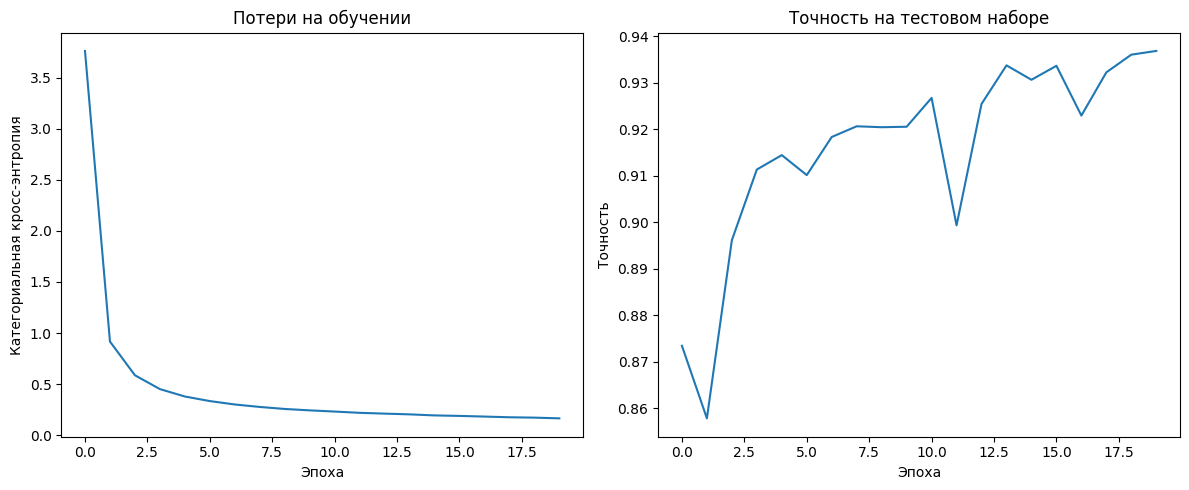

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), train_losses)
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Категориальная кросс-энтропия')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), test_accuracies)
plt.title('Точность на тестовом наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность')

plt.tight_layout()
plt.show()

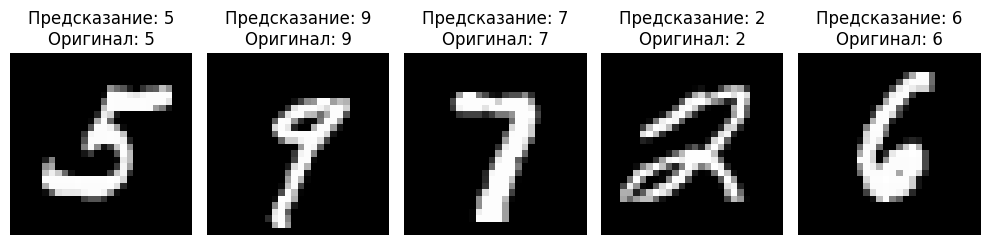

In [11]:
# Визуализация 
num_examples_to_show = 5
random_indices = np.random.choice(x_test.shape[0], num_examples_to_show, replace=False)
example_images = x_test[random_indices]
example_labels_orig = y_test_orig[random_indices]

predictions = model.predict(example_images)

plt.figure(figsize=(10, 4))
for i in range(num_examples_to_show):
    plt.subplot(1, num_examples_to_show, i + 1)
    plt.imshow(example_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Предсказание: {predictions[i]}\nОригинал: {example_labels_orig[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()